# Поведение клиентов мобильного приложения для покупки продуктов
* воронка продаж
* A/A/B-тест

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#A/B-тестирование" data-toc-modified-id="A/B-тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>A/B-тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
import plotly.express as px

from plotly.subplots import make_subplots
from plotly import graph_objects as go 
from scipy import stats as st
from io import StringIO 

import re
import requests
import warnings 
import openpyxl
import kaleido

In [2]:
pd.set_option('chained_assignment', None)

In [3]:
data = pd.read_csv('/datasets/logs_exp.csv', sep ='\t')

## Изучение данных 

In [4]:
data.info() 
print('\nКоличество повторяющихся строк —', data.duplicated().sum())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество повторяющихся строк — 413


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b>Вывод</b><br>
<li>удалить дубликаты</li>
<li>переименовать столбцы по <b>snake case</b></li>
<li>добавить столбец с датой и временем</li>
<li>добавить столбец с датой</li>
</div>

## Предобработка данных

In [5]:
column_names=[]
for column_name in data.columns:
    column_name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    column_name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', column_name).lower()
    column_names.append(column_name)
data.columns = column_names
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [6]:
data = data.drop_duplicates()
print('Количество повторяющихся строк —', data.duplicated().sum())

Количество повторяющихся строк — 0


In [7]:
data['event_datetime'] = data['event_timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))

In [8]:
data['event_date'] = data['event_datetime'].dt.date

In [9]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 07:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 14:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 14:48:42,2019-07-25


<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b>Вывод</b><br>
<li>дубликаты удалены</li>
<li>столбцы переименованы по <b>snake case</b></li>
<li>добавлен столбец с датой и временем <b>event_datetime</b></li>
<li>добавлен столбец с датой <b>event_date</b></li>
</div>

## Исследовательский анализ данных

In [10]:
def data_stat(data):
    data_stat = data.agg({'event_name':'count', 'device_id_hash':'nunique'}).\
                                           rename(index={'event_name':'events_cnt', 'device_id_hash':'users_cnt'}).to_frame().T
    data_stat['min_date'] = data['event_date'].min()
    data_stat['max_date'] = data['event_date'].max()
    data_stat['period'] = data_stat['max_date']  - data_stat['min_date']
    data_stat['events_per_user'] = (data_stat['events_cnt']/data_stat['users_cnt']).round(2)   
    return data_stat

In [11]:
data_stat(data)

,events_cnt,users_cnt,min_date,max_date,period,events_per_user
0,243713,7551,2019-07-25,2019-08-08,14 days,32.28


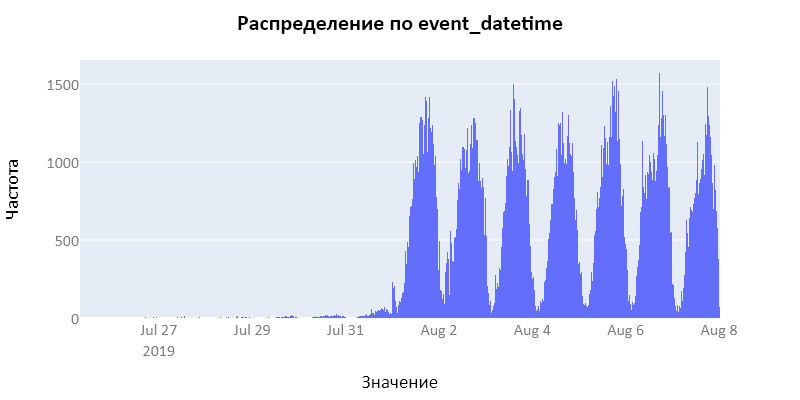

In [12]:
fig = px.histogram(data, x ='event_datetime', nbins=1000)
fig.update_layout(
        title='<b>Распределение по %s</b>'%('event_datetime'), title_x=0.5, title_font_color = 'black',
        xaxis_title='Значение', xaxis_title_font_color = 'black',
        yaxis_title='Частота', yaxis_title_font_color = 'black',
        width=800,
        height=400,
        font=dict(family='Calibri, monospace', size=16, color='#7f7f7f'))
fig.show('png')

In [13]:
data_2 = data[data['event_date'].astype(str)>='2019-08-01']

In [14]:
data_2['event_date'] = pd.to_datetime(data_2['event_date'])
data_stat(data_2)

,events_cnt,users_cnt,min_date,max_date,period,events_per_user
0,241724,7538,2019-08-01,2019-08-08,7 days,32.07


In [15]:
print('Выпало событий —', 243713 - 240887,',', ((243713 - 240887)*100/240887), 
      '\nВыпало пользователей —',7551 - 7534,',', (7551 - 7534)*100/7551)

Выпало событий — 2826 , 1.1731641807154392 
Выпало пользователей — 17 , 0.22513574361011787


In [16]:
data_2['exp_id'].value_counts()

248    84875
246    79556
247    77293
Name: exp_id, dtype: int64

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b>Вывод</b><br>
<li>данные относятся к периоду с 25 июля по 8 августа 2019 (13 дней)</li>
<li>распределение данных по дате и времени скошено вправо, до 1 августа логов очень мало</li>
<li>т.е. следует рассматривать только август — <b>data_2</b></li>
<li>при удалении старых данных выпало меньше 2% событий и меньше 1% процента пользователей</li>
<li>и остались пользователи из всех трёх экспериментальных групп</li>
</div>

## Воронка событий

In [17]:
data_2['event_name'].value_counts().to_frame().reset_index().rename(columns={'index':'event_name', 'event_name':'events_cnt'})

,event_name,events_cnt
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


In [18]:
def count_funnel(data):
    funnel = data.groupby('event_name').agg(users_cnt=('device_id_hash','nunique')).reset_index().sort_values(by='users_cnt'
                                                                                                   ,ascending=False).\
                                                                                                    reset_index(drop=True) [:-1]
    funnel['users_pct'] = round(funnel['users_cnt']/(7534)*100,2)
    funnel['users_prev_pct'] = np.nan
    for i in range(len(funnel))[1:]:    
        funnel['users_prev_pct'][i] = round(funnel['users_cnt'][i]*100/funnel['users_cnt'][i-1],2)
    return funnel

In [19]:
funnel = count_funnel(data_2) # [:-1]
funnel

,event_name,users_cnt,users_pct,users_prev_pct
0,MainScreenAppear,7423,98.53,NaN
1,OffersScreenAppear,4597,61.02,61.93
2,CartScreenAppear,3736,49.59,81.27
3,PaymentScreenSuccessful,3540,46.99,94.75


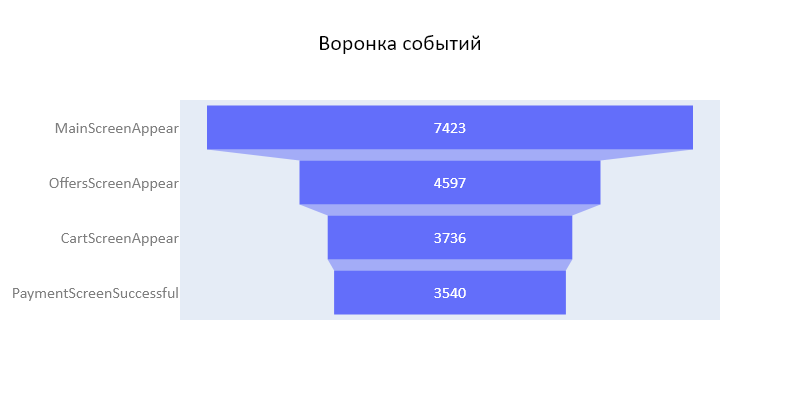

In [20]:
fig = go.Figure(
    go.Funnel(
        y=funnel[funnel['event_name']!='Tutorial']['event_name'],
        x=funnel['users_cnt']
    )
)
fig.update_layout(
        title='Воронка событий', title_x=0.5, title_font_color = 'black',
        width=800,
        height=400,
        font=dict(family='Calibri, monospace', size=16, color='#7f7f7f'))
fig.show('png')

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b>Вывод</b><br>
<li>самые частые события в приложении совпадают с самыми популярными у пользователей</li>
<li>в воронку не входит только событие <b>Tutorial</b> — обучение работе с приложением, оно же самое редкое</li>
<li>больше всего пользователей отпадает на этапе перехода с главного экрана на экран каталога</li>
<li>от главного экрана (первое событие) до оплаты доходит чуть меньше половмны пользователей (около 47%)</li>
</div>

## A/B-тестирование
* А — 246 и 247
* B — 248

In [21]:
group_users_all = list()
for group in data_2['exp_id'].unique():
    group_users = data_2[data_2['exp_id']==group]['device_id_hash'].to_list()
    group_users_all.append(group_users)

In [22]:
len(set(group_users_all[0]).intersection(set(group_users_all[1]))) 
+ len(set(group_users_all[0]).intersection(set(group_users_all[2]))) 
+ len(set(group_users_all[1]).intersection(set(group_users_all[2])))

0

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">
<b>Вывод</b><br>
Пользователей, попавших в более чем одну группу, не обнаружено.
</div>

In [23]:
groups_all = data_2.groupby('exp_id').agg(users_cnt=('device_id_hash','nunique')).reset_index()
groups_all

,exp_id,users_cnt
0,246,2484
1,247,2517
2,248,2537


<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">
<b>Вывод</b><br>
В группах примерно одинаковое количество пользователей. Стоит утонить механику разбиения пользователей на группы.
</div>

In [24]:
funnel_246 = count_funnel(data_2.query('exp_id ==246'))
funnel_247 = count_funnel(data_2.query('exp_id ==247'))

In [25]:
funnel_246

,event_name,users_cnt,users_pct,users_prev_pct
0,MainScreenAppear,2450,32.52,NaN
1,OffersScreenAppear,1542,20.47,62.94
2,CartScreenAppear,1266,16.80,82.10
3,PaymentScreenSuccessful,1200,15.93,94.79


In [26]:
funnel_247

,event_name,users_cnt,users_pct,users_prev_pct
0,MainScreenAppear,2479,32.90,NaN
1,OffersScreenAppear,1524,20.23,61.48
2,CartScreenAppear,1239,16.45,81.30
3,PaymentScreenSuccessful,1158,15.37,93.46


In [27]:
def compare_funnels(data_1, data_2, column, len_1, len_2):
    alpha = 1-(1-0.05)**(1/16)
    distr = st.norm(0, 1)
    i = 0
    while i < len(data_1):
        p1 = data_1[column][i] / len_1
        p2 = data_2[column][i] / len_2
        diff = p1 - p2
        p_combined = (data_1[column][i] + data_2[column][i]) / (len_1 + len_2)
        z = diff / mth.sqrt(p_combined*(1 - p_combined)*(1/len_1 + 1/len_2))
        p_value = (1 - distr.cdf(abs(z))) * 2
        if p_value < alpha:
            print('Шаг {} — p-value = {} — между конверсиями есть значимая разница'.format(i, p_value))
        else:
            print('Шаг {} — p-value = {} — нет оснований считать конверсии разными'.format(i, p_value))  
        i = i+1

In [28]:
compare_funnels(funnel_246, funnel_247, 'users_cnt', groups_all['users_cnt'][0],groups_all['users_cnt'][1])

Шаг 0 — p-value = 0.6756217702005545 — нет оснований считать конверсии разными
Шаг 1 — p-value = 0.26698769175859516 — нет оснований считать конверсии разными
Шаг 2 — p-value = 0.2182812140633792 — нет оснований считать конверсии разными
Шаг 3 — p-value = 0.10298394982948822 — нет оснований считать конверсии разными


<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">
<b>Вывод</b><br>
Выборки 246 и 247 не отличаются.
</div>

In [29]:
funnel_248 = count_funnel(data_2.query('exp_id ==248'))
funnel_246_247 = count_funnel(data_2.query('exp_id !=248'))

In [30]:
compare_funnels(funnel_246, funnel_248, 'users_cnt', groups_all['users_cnt'][0],groups_all['users_cnt'][2])

Шаг 0 — p-value = 0.34705881021236484 — нет оснований считать конверсии разными
Шаг 1 — p-value = 0.20836205402738917 — нет оснований считать конверсии разными
Шаг 2 — p-value = 0.08328412977507749 — нет оснований считать конверсии разными
Шаг 3 — p-value = 0.22269358994682742 — нет оснований считать конверсии разными


In [31]:
compare_funnels(funnel_247, funnel_248, 'users_cnt', groups_all['users_cnt'][1],groups_all['users_cnt'][2])

Шаг 0 — p-value = 0.6001661582453706 — нет оснований считать конверсии разными
Шаг 1 — p-value = 0.8835956656016957 — нет оснований считать конверсии разными
Шаг 2 — p-value = 0.6169517476996997 — нет оснований считать конверсии разными
Шаг 3 — p-value = 0.6775413642906454 — нет оснований считать конверсии разными


In [32]:
compare_funnels(funnel_246_247, funnel_248, 'users_cnt', groups_all['users_cnt'][0]+groups_all['users_cnt'][1]
                ,groups_all['users_cnt'][2])

Шаг 0 — p-value = 0.39298914928006035 — нет оснований считать конверсии разными
Шаг 1 — p-value = 0.418998284007599 — нет оснований считать конверсии разными
Шаг 2 — p-value = 0.19819340844527744 — нет оснований считать конверсии разными
Шаг 3 — p-value = 0.6452057673098244 — нет оснований считать конверсии разными


<div style="border-radius: 15px; border: 3px solid purple; padding: 15px;">
<b>Вывод</b><br>
Изменение шрифта не повлияло на конверсию: конверсии в каждой из контрольных и объединённой контрольной группах не отличаются от конверсий в экспериментальной группе.
</div>

## Общий вывод

* в логах обнаружены дубликаты, стоит проверить логирование
* группы A/B теста не одникового размера, нужно уточнить механизм разбиения пользователей на группы
* не все пользователи попадают на главный экран (около 98%): не открывают приложение или экран не загружается
* больше всего пользователей отваливается на этапе перехода с главного экрана на экран каталога
* от главного экрана до оплаты доходит чуть меньше половмны пользователей (около 47%)
* изменение шрифта не повлияло на конверсию, т.е. не испугало пользователей, но и не привлекло: можно поменять, если хочется, но толка от этого не будет